# Cox regression and hazard ratio model

Cox fa analisi di ogni variabile data e predice per ognuna l'hazard ratio, ovvero una probabilità, che se >1 indica che il rischio dell'accadere dell'evento aumenta all'aumentare del valore di quella variabile (o presenza di quella variabile in caso di booleane), mentre diminuisce se l'hazard ratio è <1. 


Input : feature vectors con età del paziente alla diagnosi, last days to follow-up, evento morte booleano, miRNA-seq vector con valori normalizzati con log e quantile.

Pipeline:
   - Scaling con **Z-scaler** su campi di età e miRNA-seq
   - Applicazione di elsatic net tramite ```scikit-survival.CoxnetSurvivalAnalysis``` da addestrare (scikit-survival at: https://scikit-survival.readthedocs.io/en/stable/user_guide/coxnet.html)
      - Applicare grid search e K-fold cross validation per capire set di parametri migliori
   - Calcolo di risk score con funzione di predict
        - possibile prevedere survival function o cumulative hazard function anche, ma necessario fare fine tuning con parametro ```fit_baselin_model=True```

Motivazioni:
   - Z-scaler per portare valori predittivi su stessa scala con varianza 1 e media 0
   - Utilizzo di Cox con penalizzazione per fare feature selection e selezionare solo miRNA con maggiore rilevanza
   - Utilizzo Elastic Net poichè Lasso-Cox normale non ottimale per due motivi: non può selezionare più features di quanti sample ci sono e in gruppo di features con alta correlazione tra loro ne sceglie a caso solo una tra queste. Elastic net risolve questi usando combinazione di l1 e l2 e rendendo più robusto

## Init

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [11]:
base = os.path.basename(os.getcwd())
list = os.getcwd().split(os.sep) 
list.pop(list.index(base))
ROOT = '\\'.join(list)
print(ROOT)
DATA_PATH = os.path.join(ROOT, 'datasets\\preprocessed')

d:\Universita\2 anno magistrale\Progetto BioInf\miRNA_to_age


In [ ]:
# available datasets:
#   clinical_miRNA_normalized_log.csv
#   clinical_miRNA_normalized_quant.csv
#   mRNA\\clinical_mRNA_normalized_log.csv
#   mRNA\\clinical_mRNA_normalized_tpm_log.csv
dataset = pd.read_csv(os.path.join(DATA_PATH, 'clinical_miRNA_normalized_log.csv'))

In [13]:
print(dataset.shape)
print(dataset.columns)
# print(dataset.head())
print(type(dataset.iloc[0]['days_to_death']))

(746, 951)
Index(['days_to_death', 'age_at_initial_pathologic_diagnosis',
       'days_to_last_followup', 'Death', 'pathologic_stage_Stage I',
       'pathologic_stage_Stage IA', 'pathologic_stage_Stage IIA',
       'pathologic_stage_Stage IIB', 'pathologic_stage_Stage IIIA',
       'pathologic_stage_Stage IIIC',
       ...
       'hsa-mir-934', 'hsa-mir-935', 'hsa-mir-937', 'hsa-mir-938',
       'hsa-mir-939', 'hsa-mir-940', 'hsa-mir-942', 'hsa-mir-943',
       'hsa-mir-944', 'hsa-mir-95'],
      dtype='object', length=951)
<class 'numpy.float64'>


## Hyper-parameters

In [14]:
num_folds = 20
SEED = 42

## Data

In [ ]:
y_cols = ['Death', 'days_to_death', 'days_to_last_followup']
X_cols = [col for col in dataset.columns if col not in y_cols]

custom_dtype = np.dtype([
    ('event', np.bool_),         # O 'bool'
    ('time', np.float64)      # O 'float'
])

y = []
for index,row in dataset[y_cols].iterrows():
    if row['Death'] == 1:
        y.append(np.array((True, row['days_to_death'].item()), dtype=custom_dtype))
    elif row['Death'] == 0:
        tuple = (False, row['days_to_last_followup'].item())
        y.append(np.array(tuple, dtype=custom_dtype)) 
y = np.array(y)

X = dataset[X_cols]


## Z-scaling

In [17]:
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# minmax = MinMaxScaler(feature_range=(0,15))

scaled_X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
# minmaxed_X = pd.DataFrame(minmax.fit_transform(scaled_X), columns = scaled_X.columns)

## Data splitting

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=SEED)

## K-fold

In [18]:
from sklearn.model_selection import KFold, StratifiedKFold

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)
# kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)

## Elastic net (Lasso-Cox)

In [19]:
def plot_coefficients(coefs):
    _, ax = plt.subplots(figsize=(9, 6))
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    ax.yaxis.set_label_position("left")
    ax.yaxis.tick_left()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")
    ax.legend(loc='best')

### Gridsearch for best paramters

In [31]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import warnings
from sklearn.exceptions import FitFailedWarning

first random search for l1_ratio and alpha_min_ratio

In [29]:
cen = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.05)

rcv = GridSearchCV(
    cen,
    param_grid={
        "l1_ratio": [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        "alpha_min_ratio":[0.01, 0.05, 0.1]
    },
    cv=kfold,
    error_score=0.5,
    n_jobs=8,
).fit(X_train, y_train)

print(rcv.best_params_)

{'alpha_min_ratio': 0.05, 'l1_ratio': 0.3}


then extract estimated alphas

In [30]:
cen = make_pipeline(CoxnetSurvivalAnalysis(**rcv.best_params_))

# warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)

cen.fit(X_train, y_train)
estimated_alphas = cen.named_steps["coxnetsurvivalanalysis"].alphas_

and perform another random search for alphas values

In [ ]:
def c_index_scorer(estimator, X, y):
    # Estrai i campi 'death' e 'days' da y
    event_indicator = y['event']
    event_time = y['time']
    # Predici i punteggi di rischio
    risk_scores = estimator.predict(X)
    # Calcola il concordance index
    c_index = concordance_index_censored(event_indicator, event_time, risk_scores)[0]
    return c_index

cen = CoxnetSurvivalAnalysis(**rcv.best_params_)

gcv = RandomizedSearchCV(
    cen,
    param_distributions={
        "alphas":[[v] for v in map(float, estimated_alphas)]
    },
    cv=kfold,
    scoring=c_index_scorer,
    error_score=0.5,
    n_iter=30,
    n_jobs=8,
).fit(X_train, y_train)

res = pd.DataFrame(gcv.cv_results_)
print(gcv.best_params_)

In [18]:
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alphas,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,mean_test_score,std_test_score,rank_test_score
0,0.486383,0.034015,0.065805,0.004717,[0.33879079031068987],{'alphas': [0.33879079031068987]},0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,1
1,0.477849,0.035049,0.065444,0.011786,[0.30159667234442283],{'alphas': [0.30159667234442283]},0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,1
2,0.452390,0.021966,0.071318,0.013441,[0.7470779861101506],{'alphas': [0.7470779861101506]},0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,1
3,0.460110,0.022397,0.069661,0.013325,[0.8791703034554935],{'alphas': [0.8791703034554935]},0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,1
4,0.436263,0.011682,0.069207,0.017275,[0.28788863812071364],{'alphas': [0.28788863812071364]},0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,1
5,0.490521,0.043362,0.072176,0.014300,[0.4802271919029562],{'alphas': [0.4802271919029562]},0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,1
6,0.449189,0.034384,0.063994,0.020474,[0.4080747063362968],{'alphas': [0.4080747063362968]},0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,1
7,0.445773,0.021571,0.062980,0.015169,[0.2335153502137659],{'alphas': [0.2335153502137659]},0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,1
8,0.431117,0.013871,0.063491,0.012257,[0.2812700660372505],{'alphas': [0.2812700660372505]},0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,1
9,0.439511,0.007694,0.057502,0.006479,[1.1622114006471833],{'alphas': [1.1622114006471833]},0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,1


In [21]:
np.argmax(res.mean_test_score)

np.int64(0)

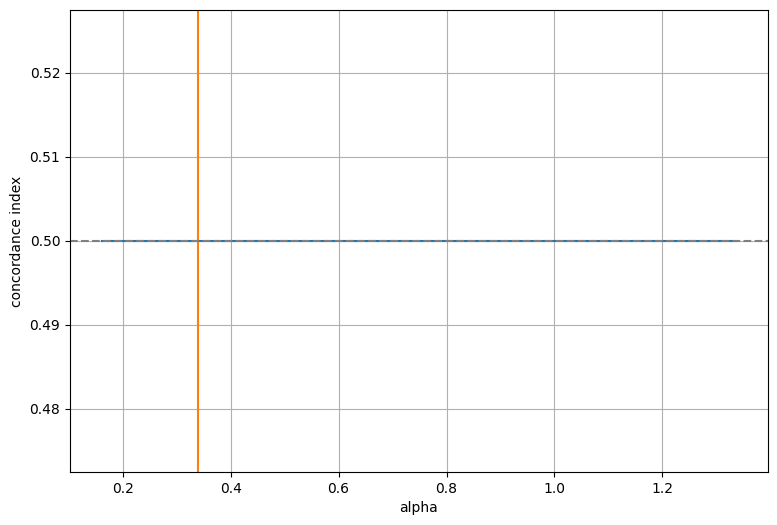

In [22]:
alphas = res['param_alphas'].map(lambda x: x[0]).sort_values()
mean = res.mean_test_score
std = res.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
# ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [23]:
cen_best = CoxnetSurvivalAnalysis(**rcv.best_params_, alphas=gcv.best_params_['alphas'], max_iter=100000) # for predicting just the risk score
cen_best.fit(scaled_X, y)
print("\nFinished training cen_best\n")

pred_res = cen_best.predict(scaled_X)
print(pred_res[:10])

best_vars = X_train.columns[np.where(cen_best.coef_ != 0)[0]]
print(f"Kept {len(best_vars)} variables for infer: {best_vars}\n")

print("Beginning cross validation on test")
cv = cross_val_score(cen_best, scaled_X, y, cv=kfold, scoring=c_index_scorer)
print(f"Cross validation scores: {cv}")
print(f"Cross validation average: {cv.mean()}")

C:\Users\Matteo Bulgarelli\AppData\Local\Temp\ipykernel_11672\2700938266.py:2: UserWarning: all coefficients are zero, consider decreasing alpha.
  cen_best.fit(scaled_X, y)



Finished training cen_best

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Kept 0 variables for infer: Index([], dtype='object')

Beginning cross validation on test


NameError: name 'cross_val_score' is not defined

In [53]:
cv

array([0.64285714, 0.8       , 0.33333333, 0.62962963, 0.89473684,
       0.6       , 0.3125    , 0.625     , 0.53488372, 0.55737705,
       0.43055556, 0.        , 0.36363636, 0.58333333, 0.43181818,
       0.48888889, 0.16666667, 0.66666667, 0.43478261, 0.63636364])

In [18]:
X.columns[np.where(cen_best.named_steps["coxnetsurvivalanalysis"].coef_ != 0)[0]]

Index(['pathologic_stage_Stage IV', 'pathologic_stage_Stage X', 'hsa-mir-1229',
       'hsa-mir-1244-4', 'hsa-mir-129-1', 'hsa-mir-148b', 'hsa-mir-198',
       'hsa-mir-302c', 'hsa-mir-3163', 'hsa-mir-3180-5', 'hsa-mir-325',
       'hsa-mir-340', 'hsa-mir-3672', 'hsa-mir-4263', 'hsa-mir-4653',
       'hsa-mir-4719', 'hsa-mir-4798', 'hsa-mir-488', 'hsa-mir-514a-3',
       'hsa-mir-5195', 'hsa-mir-548a-1', 'hsa-mir-583', 'hsa-mir-586',
       'hsa-mir-605', 'hsa-mir-623', 'hsa-mir-640', 'hsa-mir-6830',
       'hsa-mir-7155', 'hsa-mir-7705', 'hsa-mir-7977', 'hsa-mir-8069-1',
       'hsa-mir-8085'],
      dtype='object')

In [26]:
cen_best_for_func = make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=0.9, alphas=[0.0337], fit_baseline_model=True, max_iter=100000)) # to predict the hazard function
cen_best_for_func.fit(X_train, y_train)
print("Finished training cen_best_for_func")

Finished training cen_best_for_func


c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sklearn\pipeline.py:662: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **last_step_params["fit"])
c:\Users\Matteo Bulgarelli\anaconda3\envs\tirocinio-venv\Lib\site-packages\sksurv\linear_model\coxph.py:86: RuntimeWarning: invalid value encountered in divide
  y = np.cumsum(n_events / divisor)


In [27]:
risk_score = cen_best.predict(X_test)
surv_funcs = cen_best_for_func.predict_survival_function(X_test)
print("Finished predicting")

Finished predicting
